## Goal:
Inspect behavior of voters as a function of object parameters. Also look at some images to figure out whether or not voter behavior makes sense.

In [182]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from dateutil.parser import parse
from datetime import date
from PIL import Image
from glob import glob
import os

import sys
sys.path.append('..')
from sf import parseTime, getFilename, extract_task_value, make_df_classify, make_df_tasks_with_props, make_df_vote_threshold

%matplotlib inline

In [181]:
# reload sf import while I'm working on extracting functionality to it from notebooks
from importlib import reload
import sf
reload(sf)

<module 'sf' from '..\\sf.py'>

In [5]:
# set matplotlib plotting params:
font = {
    'family': 'Verdana',
    'weight': '300',
    'size': 12
}

rc('font', **font)

In [3]:
object_info = pd.read_csv('../../catalogue/sf_spacefluff_object_data.csv', comment="#")
candidate_names_classify = np.loadtxt('../sf_candidate_names__classification-classify.txt', dtype='str')
catalogue_targets = np.loadtxt('../../catalogue/sf_catalogue_targets.txt', dtype='str')
answer_types = ['Galaxy', 'Group of objects (Cluster)', 'Something else/empty center']

In [183]:
df = make_df_classify()
df_props = make_df_tasks_with_props(df, candidate_names_classify, object_info)

---

In [13]:
# copy-paste object props for possible later use
props = ['RA', 'DEC', 'Reff', 'r_mag', 'g_mag', 'axis_ratio', 'pos_angle', 'n', 'u', 'g', 'r', 'i', 'ue', 'ge',
       're', 'ie', 'Reffe', 'r_mage', 'ne', 'C', 'mue_r', 'bae', 'RFF']

## Inspect property distribution across all objects in SpaceFluff

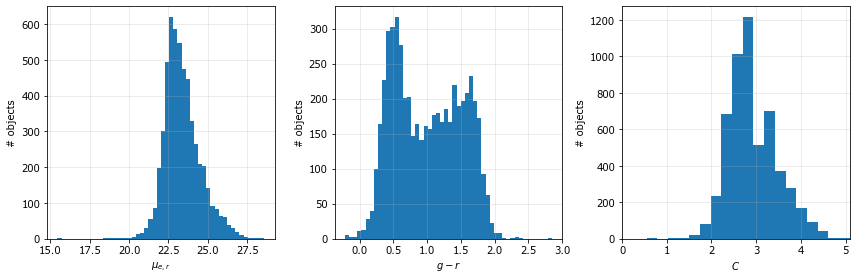

In [351]:
# surface brightness distribution of our objects

fig, fr = plt.subplots(1,3, figsize=(12,4))

fr[0].hist(df_props['mue_r'], bins=50)
fr[0].update({
    'xlabel': r"$\mu_{e,r}$",
    'ylabel': '# objects'
})

fr[1].hist(df_props['g']-df_props['r'], bins=50)
fr[1].update({
    'xlabel': r"$g-r$",
    'ylabel': '# objects',
#     'xlim': fr.get_xlim()[::-1]
})

fr[2].hist(df_props[df_props['C'] > 0]['C'], bins=20)
fr[2].update({
    'xlabel': r"$C$",
    'ylabel': '# objects',
    'xlim': [0, df_props['C'].max()]
})


for i in range(3):
    fr[i].grid(alpha=0.3, which='both')
    
fig.tight_layout()
plt.show()


## Inspect objects without props (these are presumably artifacts)

In [378]:
answers = ['% votes {}'.format(x) for x in ['Galaxy', 'Group of objects (Cluster)', 'Something else/empty center']]

In [25]:
no_props = df_props[df_props['RA'].isnull()]

print('# objects without properties: {}'.format(no_props.shape[0]))

# objects without properties: 922


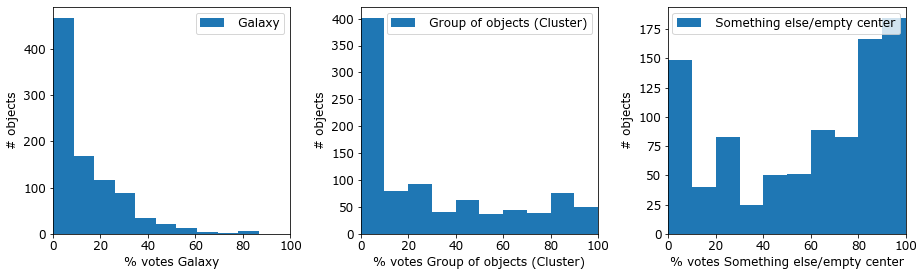

In [63]:
name, gal, group, empty = no_props[['name', *answers]]

fig, fr = plt.subplots(1,3, figsize=(13,4))

for i in range(3):
    fr[i].hist(no_props[answers[i]], label=answers[i][7:])
    fr[i].legend()
    fr[i].update({
        'xlim': [0,100],
        'xlabel': answers[i],
        'ylabel': '# objects'
    })    
    
fig.tight_layout()
plt.show()

In [196]:
# fig, fr = plt.subplots(5,5, figsize=(15,15))
# fr = np.ravel(fr)

# filtered_no_props = no_props[no_props['% votes Galaxy'] > 80]

# for i in range(25):
#     object_name = filtered_no_props.iloc[i]['name']
#     path = '../image/thumbnails/{}_insp.png'.format(object_name)
#     image = Image.open(path)
#     fr[i].imshow(image)
#     fr[i].set_title(object_name)
#     fr[i].set_axis_off()

In [211]:
# add galaxy vote count (as a number, not a percentage) column
df_props['# votes Galaxy'] = df_props['counts'].apply(lambda x: x.get('Galaxy', None))

### Percentage of votes A SINGLE OBJECT gets for 'Galaxy' compared to object's surface brightness

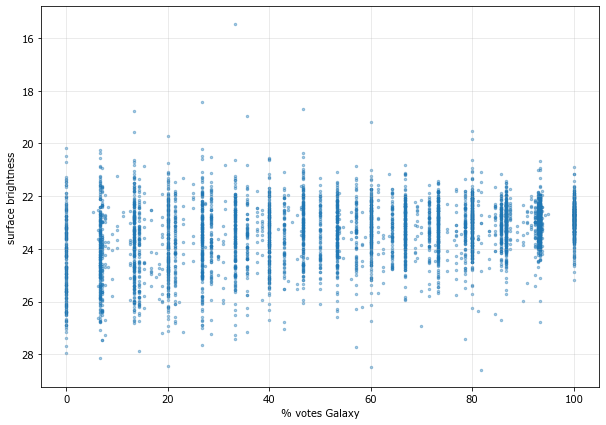

In [247]:
fig, ax = plt.subplots(figsize=(10,7))

ax.scatter(df_props['% votes Galaxy'], df_props['mue_r'], s=6, alpha=0.4)
# ax.scatter(df_props['% votes Group of objects (Cluster)'], df_props['mue_r'], s=6, alpha=0.4)
# ax.scatter(df_props['% votes Something else/empty center'], df_props['mue_r'], s=6, alpha=0.4)
ax.update({
    'xlabel': "% votes Galaxy",
    'ylabel': "surface brightness",
    'ylim': ax.get_ylim()[::-1]
})
ax.grid(alpha=0.3, which='both')

### Difference between %Bright and %Fluffy A SINGLE OBJECT gets (given that the users already voted for 'Galaxy') as a function of surface brightness

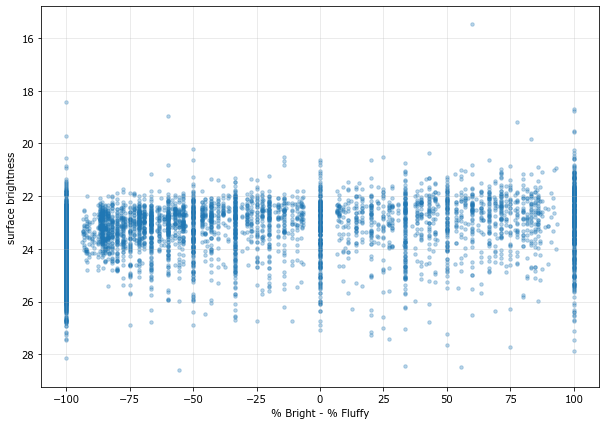

In [374]:
fig, fr = plt.subplots(figsize=(10,7))

# ax.scatter(df_props['% Fluffy'], df_props['mue_r'], s=12, alpha=0.3, marker='o')
fr.scatter(df_props['% Bright']-df_props['% Fluffy'], df_props['mue_r'], s=12, alpha=0.3, marker='o')
fr.update({
    'xlabel': "% Bright - % Fluffy",
    'ylabel': "surface brightness",
    'ylim': fr.get_ylim()[::-1]
})
fr.grid(alpha=0.3, which='both')

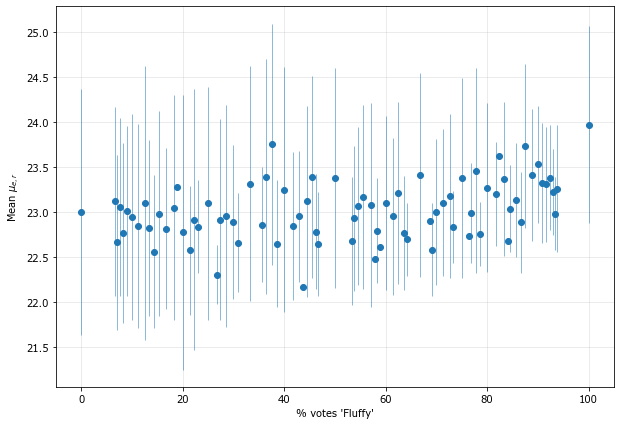

In [379]:
groupby_bright = df_props.groupby(['% Fluffy'])
sb_mean, sb_std = groupby_bright['mue_r'].agg(['mean', 'std']).T.values

bright = list(groupby_bright.groups.keys())
sb_mean = sb_mean
sb_std = sb_std

fig, fr = plt.subplots(figsize=(10,7))

fr.errorbar(x=bright, y=sb_mean, yerr=sb_std, fmt='o', elinewidth=0.5)

fr.grid(alpha=0.3, which='both')
fr.update({
    'xlabel': "% votes 'Fluffy'",
    'ylabel': r"Mean $\mu_{e,r}$"
})

plt.show()